# **Import needed libraries**

In [ ]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50


# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# **Loading the dataset**

> Read the training dataset into the dataframe

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:

# Generate data paths with labels
train_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


> read the testing dataset into the dataframe

In [ ]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

# Get folders names
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)


In [ ]:
ts_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


# **Data preprocessing**

first we will check if the training data is balanced or not

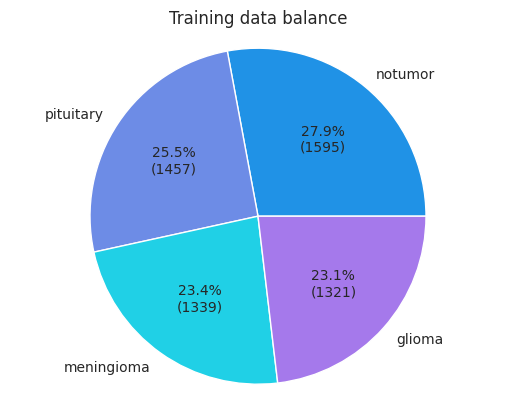

In [ ]:
data_balance = train_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

**data is balanced.**

**now we will split the testing data to test and validation data**

In [ ]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

**Create image data generator**

this step to convert these dataframes to numpy array

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


**Display sample from train data**

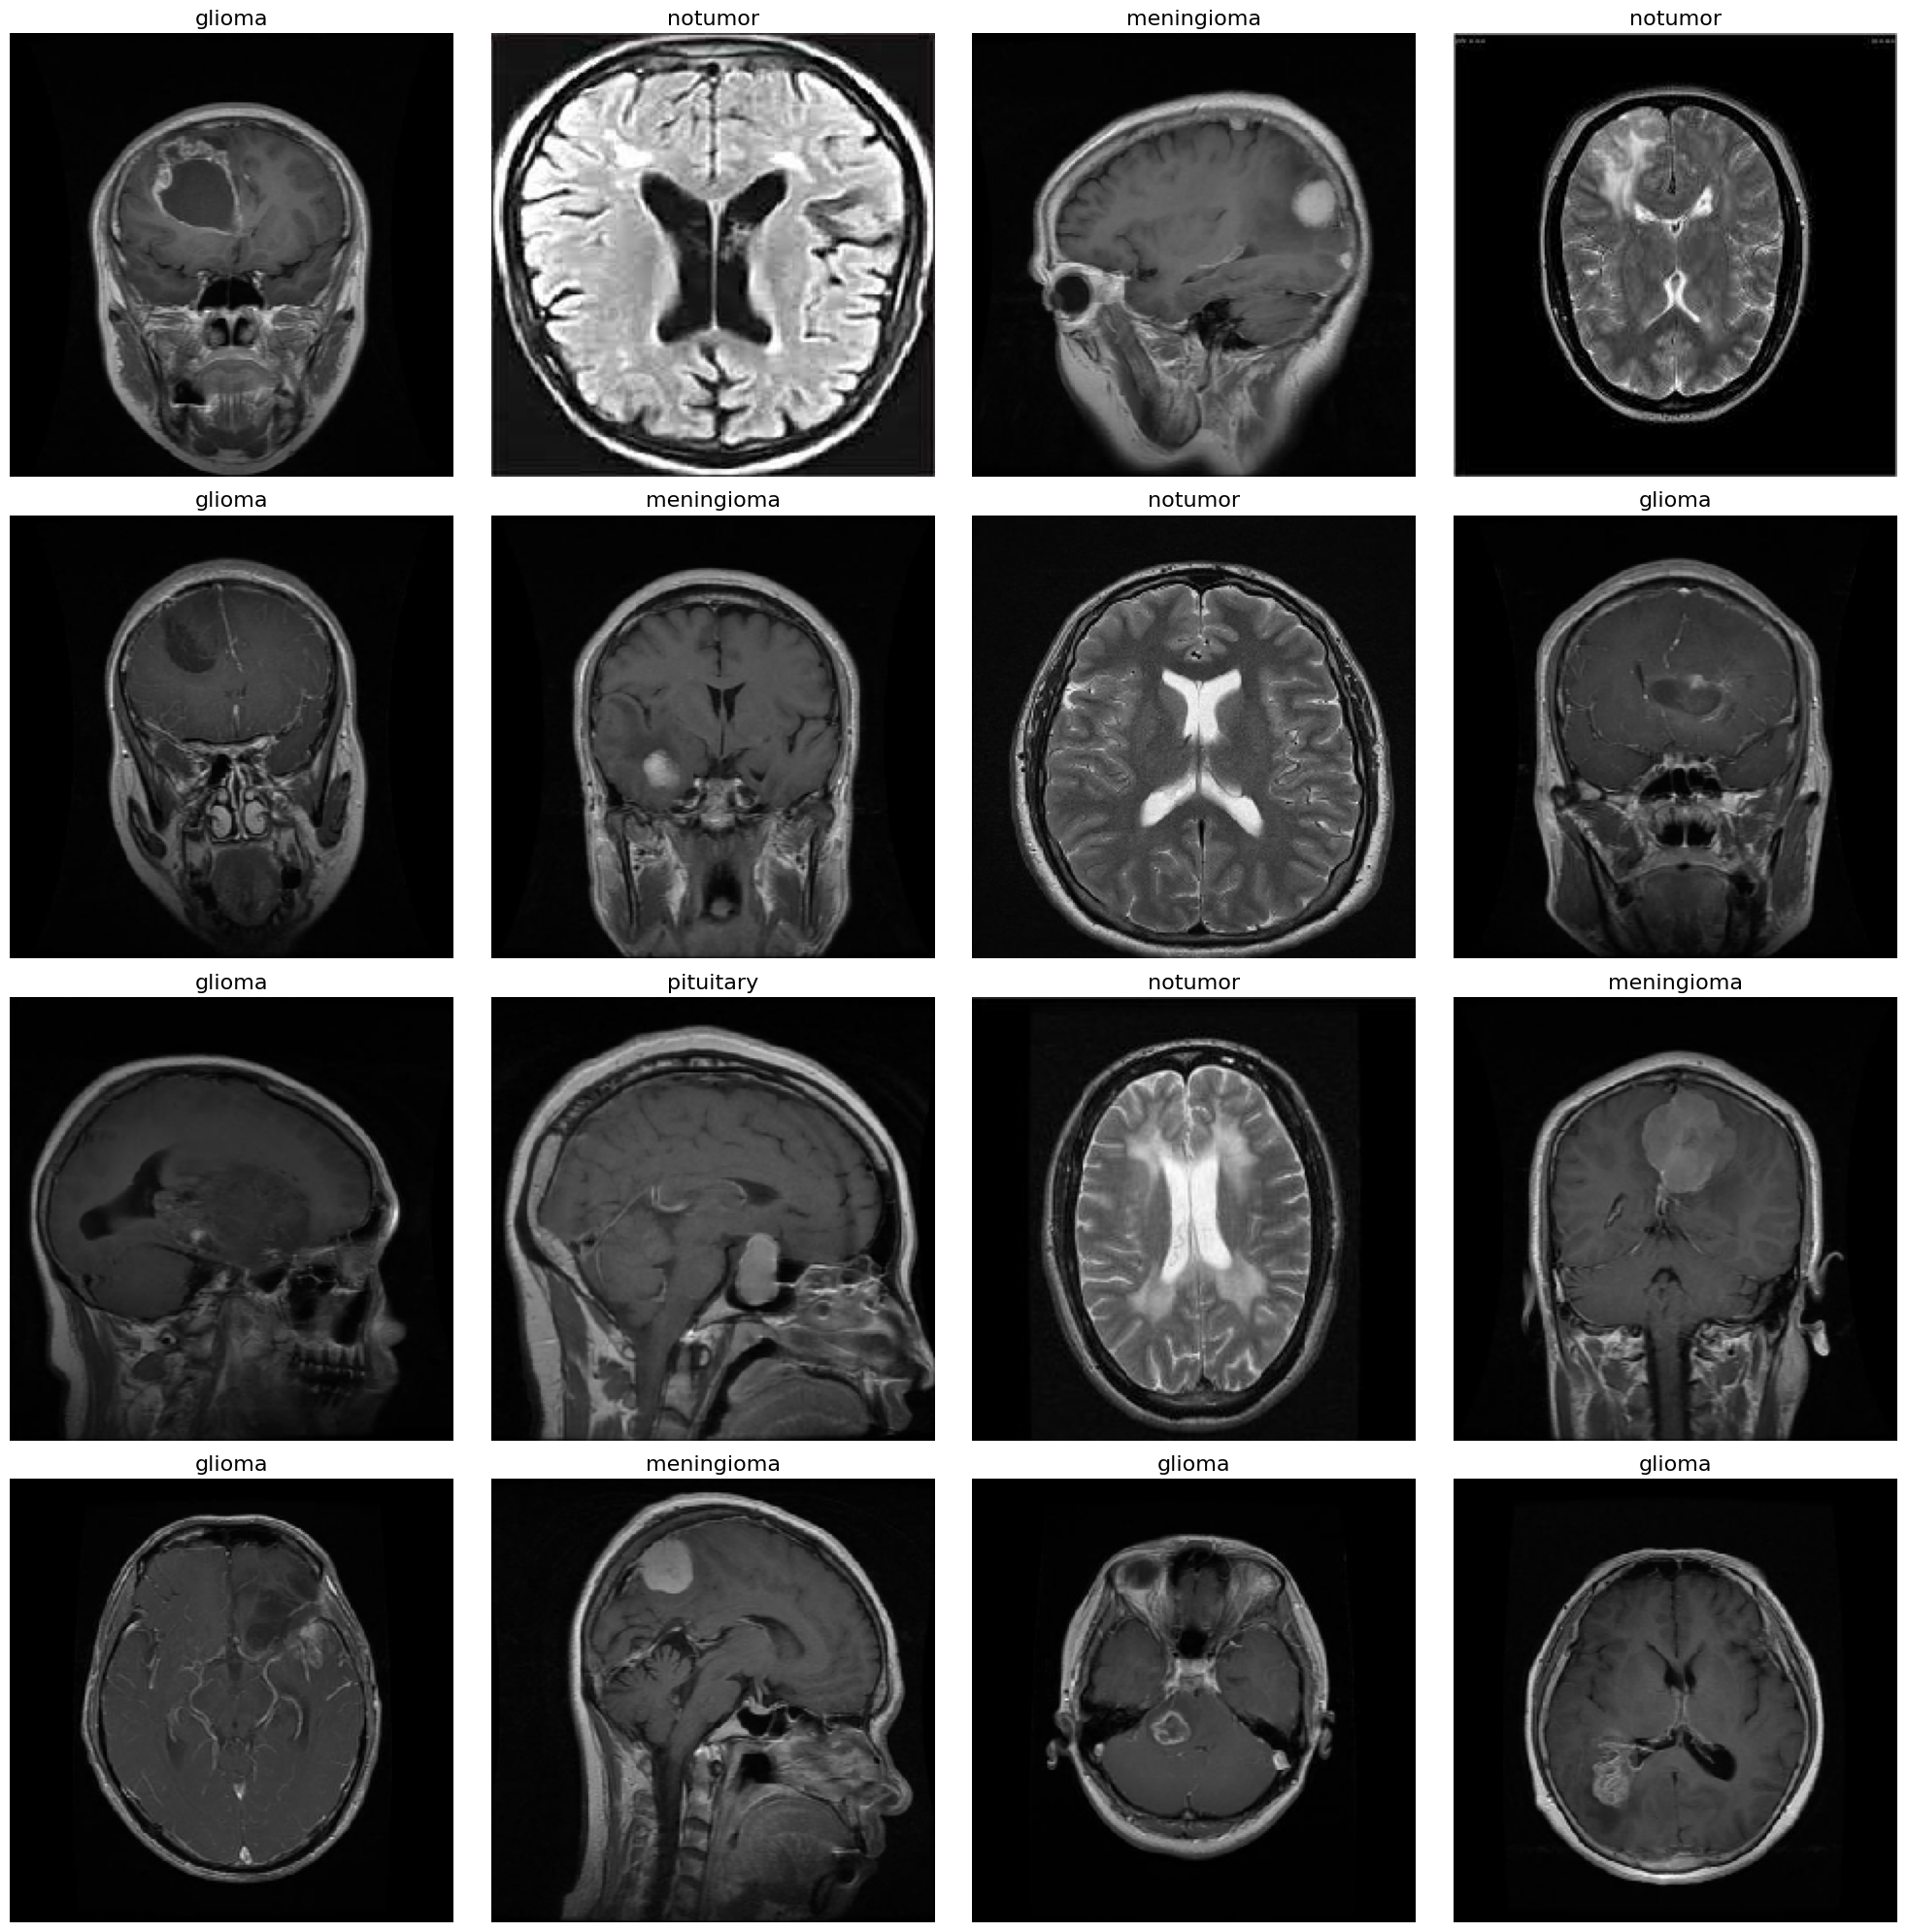

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Model Structure**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(class_count, activation = "softmax"))


In [ ]:
# Compile model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,866,724 (49.08 MB)

 Trainable params: 12,866,724 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 523s 1s/step - accuracy: 0.6048 - loss: 36.6008 - val_accuracy: 0.8916 - val_loss: 0.3301
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.9552 - loss: 0.1529 - val_accuracy: 0.9267 - val_loss: 0.1963
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.9889 - loss: 0.0426 - val_accuracy: 0.9389 - val_loss: 0.1796
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 535s 1s/step - accuracy: 0.9985 - loss: 0.0148 - val_accuracy: 0.9527 - val_loss: 0.1231
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step - accuracy: 0.9988 - loss: 0.0050 - val_accuracy: 0.9420 - val_loss: 0.1605
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 530s 1s/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9466 - val_loss: 0.1467
Epoch 7/10
269/357 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - accuracy: 1.0000 - loss: 6.6034e-04

In [ ]:
# Create a new MLP model
model2 = Sequential([
    Flatten(input_shape=img_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(class_count, activation='softmax')
])

model2.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.5433 - loss: 652.6605 - val_accuracy: 0.6519 - val_loss: 203.3437
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.7192 - loss: 101.2289 - val_accuracy: 0.7588 - val_loss: 87.4455
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.7365 - loss: 85.6301 - val_accuracy: 0.7649 - val_loss: 68.7208
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7723 - loss: 63.6886 - val_accuracy: 0.7557 - val_loss: 60.2632
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8209 - loss: 38.0962 - val_accuracy: 0.7603 - val_loss: 55.5990
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.8142 - loss: 31.6424 - val_accuracy: 0.7740 - val_loss: 33.7616
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.8198 - loss: 29.4907 - val_accuracy: 0.7557 - val_loss: 29.3994
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.8538 

In [ ]:
# Print model summary
model2.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,828,686 (220.60 MB)

 Trainable params: 19,276,228 (73.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,552,458 (147.07 MB)

In [ ]:
# Load the VGG16 model without the top (fully connected) layers
vgg_base = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the VGG16 base model
vgg_base.trainable = False

# Create a new model on top of the VGG16 base
model3 = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(class_count, activation='softmax')
])

model3.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)



Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 54s 129ms/step - accuracy: 0.7966 - loss: 9.1297 - val_accuracy: 0.9221 - val_loss: 0.3806
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.9565 - loss: 0.2110 - val_accuracy: 0.9435 - val_loss: 0.3511
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.9815 - loss: 0.0711 - val_accuracy: 0.9542 - val_loss: 0.3095
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.9831 - loss: 0.0852 - val_accuracy: 0.9298 - val_loss: 0.6311
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.9795 - loss: 0.0942 - val_accuracy: 0.9603 - val_loss: 0.2014
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.9893 - loss: 0.0412 - val_accuracy: 0.9756 - val_loss: 0.1525
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.9959 - loss: 0.0102 - val_accuracy: 0.9466 - val_loss: 0.5043
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.9959 - loss: 0

In [ ]:
# Print model summary
model3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,986,126 (129.65 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 12,847,626 (49.01 MB)

In [ ]:
# Load the ResNet50 model without the top layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the ResNet50 base model
resnet_base.trainable = False

# Create a new model on top of the ResNet50 base
model_resnet = Sequential([
    resnet_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(class_count, activation='softmax')
])

# Compile the model
model_resnet.compile(optimizer=Adamax(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history_resnet = model_resnet.fit(train_gen,
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data=valid_gen,
                                  shuffle=False)


Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.8070 - loss: 7.1232 - val_accuracy: 0.9191 - val_loss: 0.4760
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9663 - loss: 0.1630 - val_accuracy: 0.9634 - val_loss: 0.1601
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9827 - loss: 0.0675 - val_accuracy: 0.9389 - val_loss: 0.2781
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9719 - loss: 0.1336 - val_accuracy: 0.9481 - val_loss: 0.2189
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9903 - loss: 0.0373 - val_accuracy: 0.9588 - val_loss: 0.2917
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9877 - loss: 0.0467 - val_accuracy: 0.9679 - val_loss: 0.1780
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9954 - loss: 0.0187 - val_accuracy: 0.9649 - val_loss: 0.1303
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9972 - loss: 0.0074 - 

In [ ]:
model_resnet.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,661,902 (383.99 MB)

 Trainable params: 25,691,396 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 51,382,794 (196.01 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model without the top layers
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the DenseNet121 base model
densenet_base.trainable = False

# Create a new model on top of the DenseNet121 base
model_densenet = Sequential([
    densenet_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Optional but helps with generalization
    Dense(class_count, activation='softmax')
])

# Compile the model
model_densenet.compile(optimizer=Adamax(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model
history_densenet = model_densenet.fit(train_gen,
                                      epochs=epochs,
                                      verbose=1,
                                      validation_data=valid_gen,
                                      shuffle=False)


Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 66s 113ms/step - accuracy: 0.6189 - loss: 11.9967 - val_accuracy: 0.8260 - val_loss: 0.4763
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.7424 - loss: 0.6316 - val_accuracy: 0.8137 - val_loss: 0.4811
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.7943 - loss: 0.4929 - val_accuracy: 0.8626 - val_loss: 0.3849
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8089 - loss: 0.4541 - val_accuracy: 0.8519 - val_loss: 0.3700
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8371 - loss: 0.3944 - val_accuracy: 0.8733 - val_loss: 0.2887
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.8391 - loss: 0.3752 - val_accuracy: 0.9069 - val_loss: 0.2422
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.8634 - loss: 0.3321 - val_accuracy: 0.8794 - val_loss: 0.3019
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8631 - loss: 0.3376 

In [ ]:
model_densenet.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,576,526 (173.86 MB)

 Trainable params: 12,846,340 (49.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 25,692,682 (98.01 MB)

## Display Model Performance

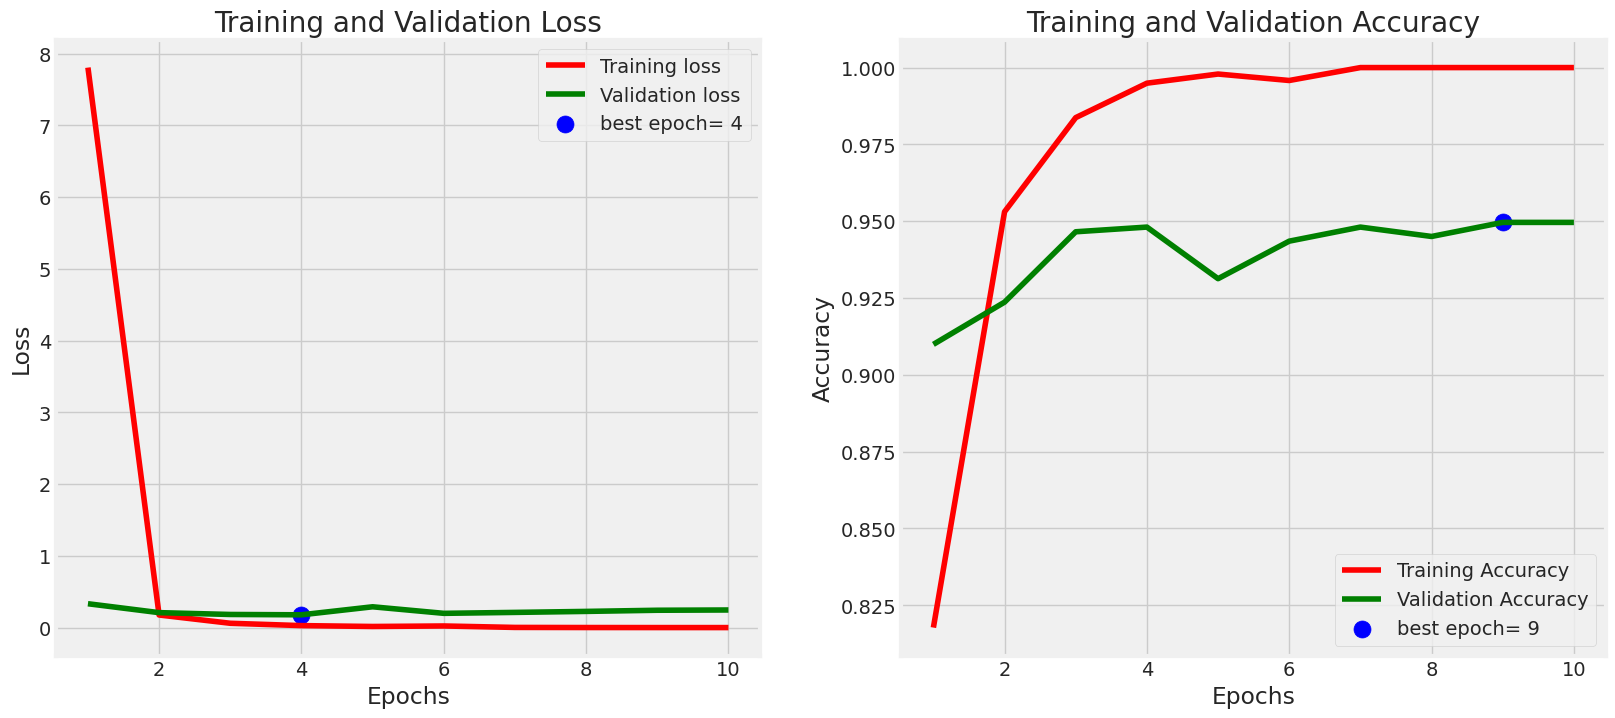

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

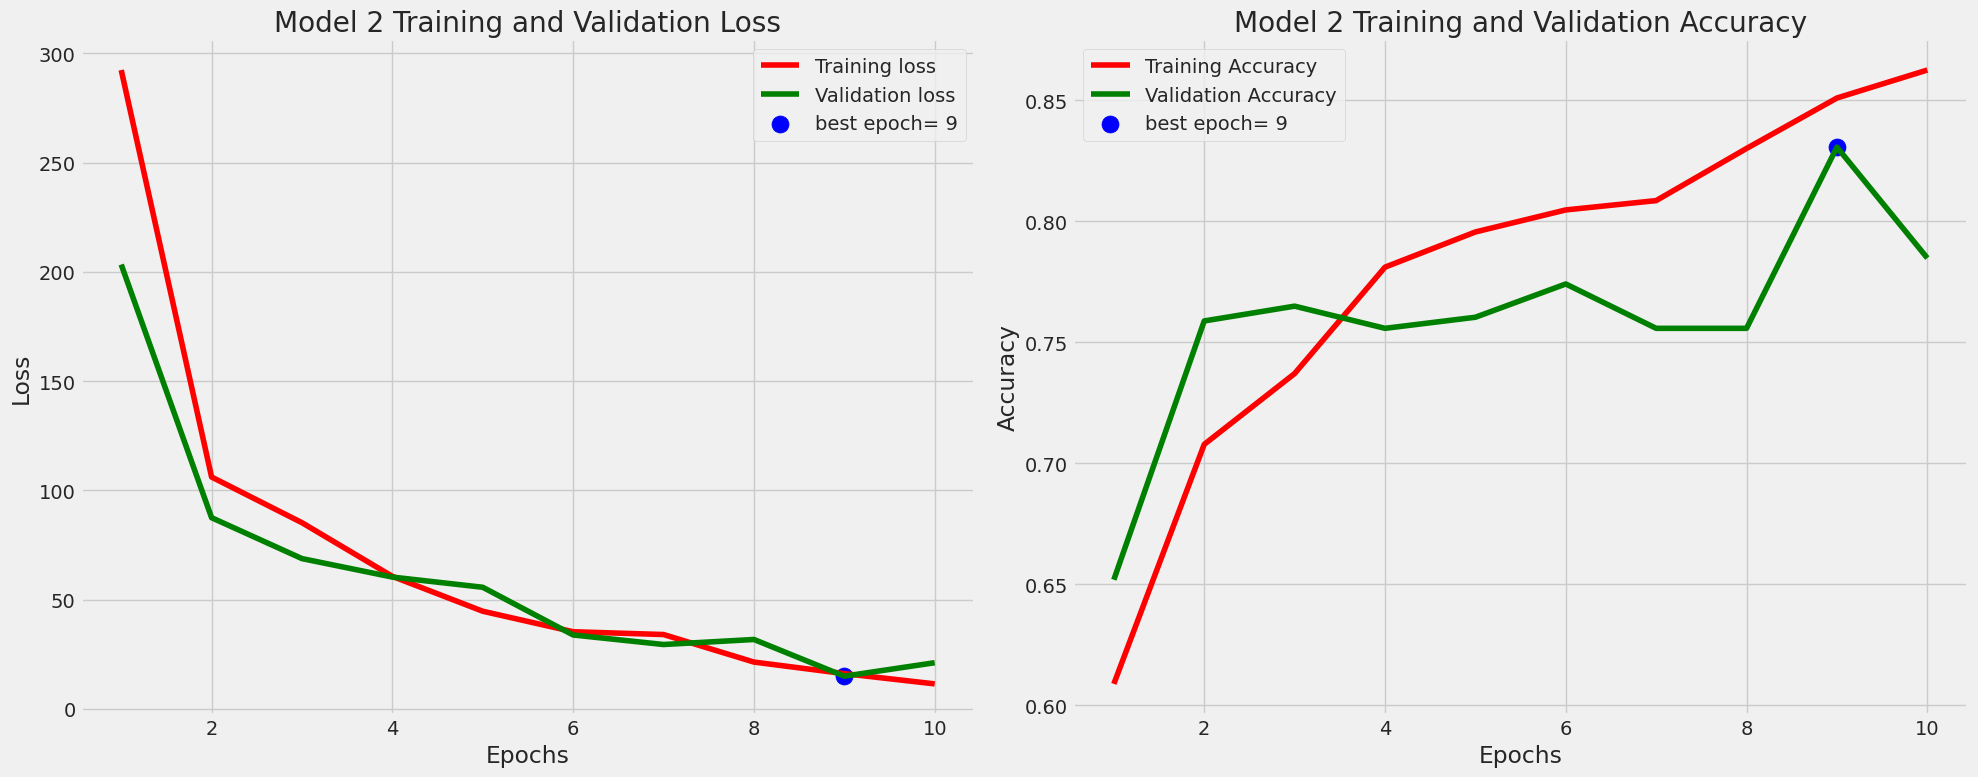

In [ ]:
# Define needed variables for model2
tr_acc_model2 = history2.history['accuracy']
tr_loss_model2 = history2.history['loss']
val_acc_model2 = history2.history['val_accuracy']
val_loss_model2 = history2.history['val_loss']
index_loss_model2 = np.argmin(val_loss_model2)
val_lowest_model2 = val_loss_model2[index_loss_model2]
index_acc_model2 = np.argmax(val_acc_model2)
acc_highest_model2 = val_acc_model2[index_acc_model2]

Epochs_model2 = [i+1 for i in range(len(tr_acc_model2))]
loss_label_model2 = f'best epoch= {str(index_loss_model2 + 1)}'
acc_label_model2 = f'best epoch= {str(index_acc_model2 + 1)}'

# Plot training history for model2
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model2, tr_loss_model2, 'r', label='Training loss')
plt.plot(Epochs_model2, val_loss_model2, 'g', label='Validation loss')
plt.scatter(index_loss_model2 + 1, val_lowest_model2, s=150, c='blue', label=loss_label_model2)
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model2, tr_acc_model2, 'r', label='Training Accuracy')
plt.plot(Epochs_model2, val_acc_model2, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model2 + 1, acc_highest_model2, s=150, c='blue', label=acc_label_model2)
plt.title('Model 2 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


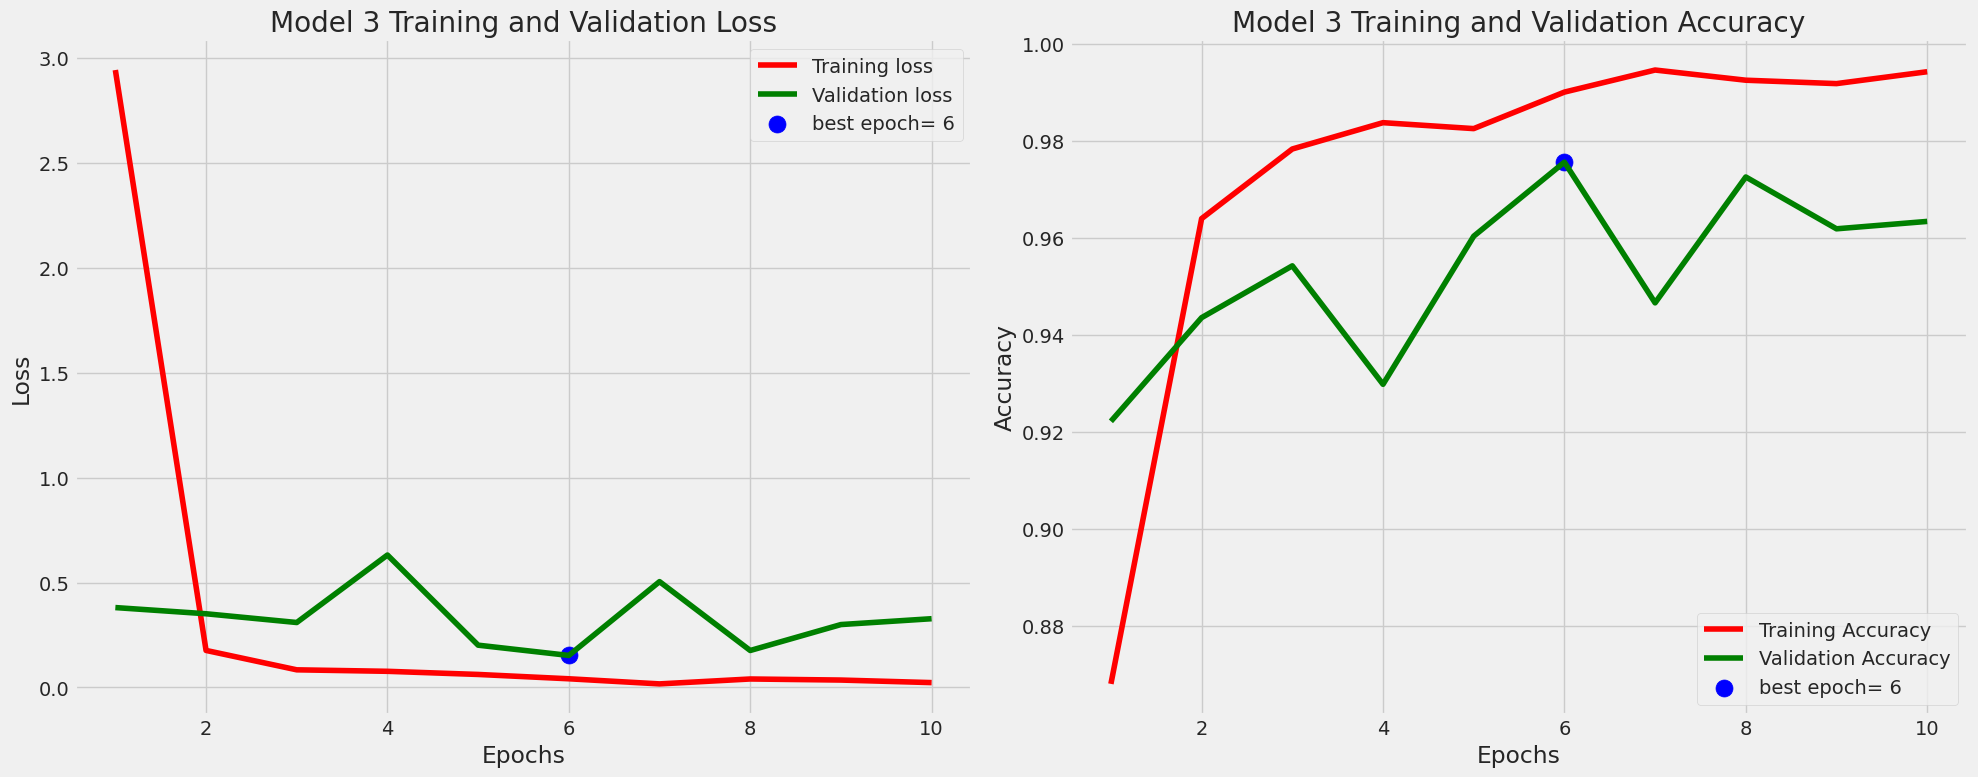

In [ ]:
# Define needed variables for model3
tr_acc_model3 = history3.history['accuracy']
tr_loss_model3 = history3.history['loss']
val_acc_model3 = history3.history['val_accuracy']
val_loss_model3 = history3.history['val_loss']
index_loss_model3 = np.argmin(val_loss_model3)
val_lowest_model3 = val_loss_model3[index_loss_model3]
index_acc_model3 = np.argmax(val_acc_model3)
acc_highest_model3 = val_acc_model3[index_acc_model3]

Epochs_model3 = [i+1 for i in range(len(tr_acc_model3))]
loss_label_model3 = f'best epoch= {str(index_loss_model3 + 1)}'
acc_label_model3 = f'best epoch= {str(index_acc_model3 + 1)}'

# Plot training history for model3
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model3, tr_loss_model3, 'r', label='Training loss')
plt.plot(Epochs_model3, val_loss_model3, 'g', label='Validation loss')
plt.scatter(index_loss_model3 + 1, val_lowest_model3, s=150, c='blue', label=loss_label_model3)
plt.title('Model 3 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model3, tr_acc_model3, 'r', label='Training Accuracy')
plt.plot(Epochs_model3, val_acc_model3, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model3 + 1, acc_highest_model3, s=150, c='blue', label=acc_label_model3)
plt.title('Model 3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


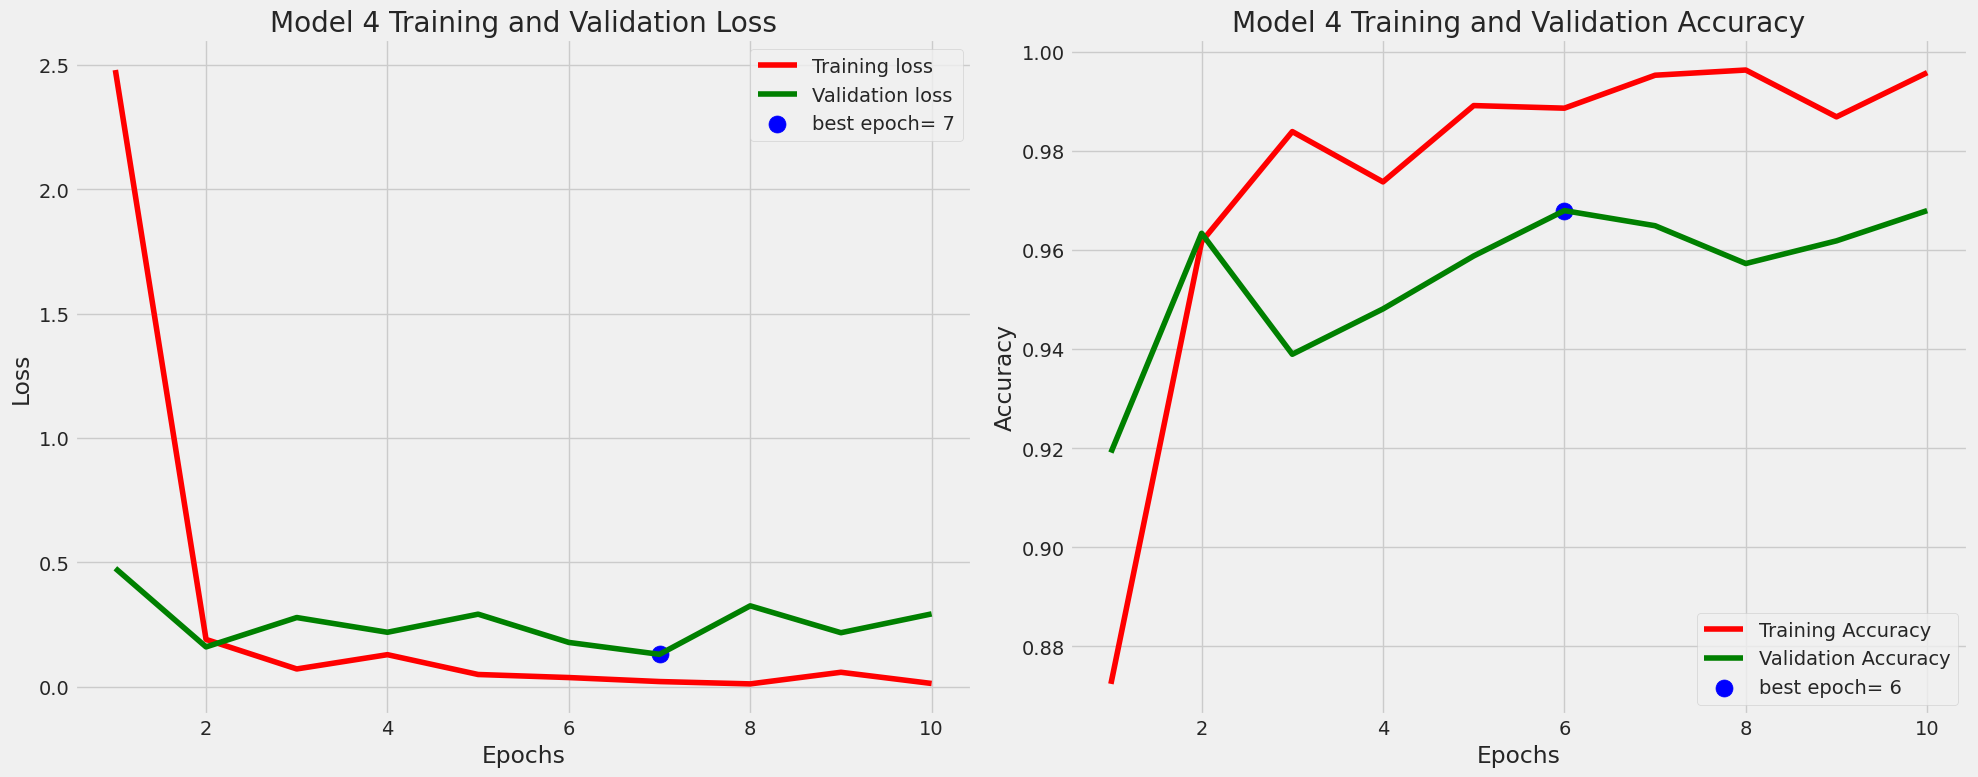

In [ ]:
# Define needed variables for model_resnet
tr_acc_model4 = history_resnet.history['accuracy']
tr_loss_model4 = history_resnet.history['loss']
val_acc_model4 = history_resnet.history['val_accuracy']
val_loss_model4 = history_resnet.history['val_loss']
index_loss_model4 = np.argmin(val_loss_model4)
val_lowest_model4 = val_loss_model4[index_loss_model4]
index_acc_model4 = np.argmax(val_acc_model4)
acc_highest_model4 = val_acc_model4[index_acc_model4]

Epochs_model4 = [i+1 for i in range(len(tr_acc_model4))]
loss_label_model4 = f'best epoch= {str(index_loss_model4 + 1)}'
acc_label_model4 = f'best epoch= {str(index_acc_model4 + 1)}'

# Plot training history for model4
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model4, tr_loss_model4, 'r', label='Training loss')
plt.plot(Epochs_model4, val_loss_model4, 'g', label='Validation loss')
plt.scatter(index_loss_model4 + 1, val_lowest_model4, s=150, c='blue', label=loss_label_model4)
plt.title('Model 4 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model4, tr_acc_model4, 'r', label='Training Accuracy')
plt.plot(Epochs_model4, val_acc_model4, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model4 + 1, acc_highest_model4, s=150, c='blue', label=acc_label_model4)
plt.title('Model 4 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


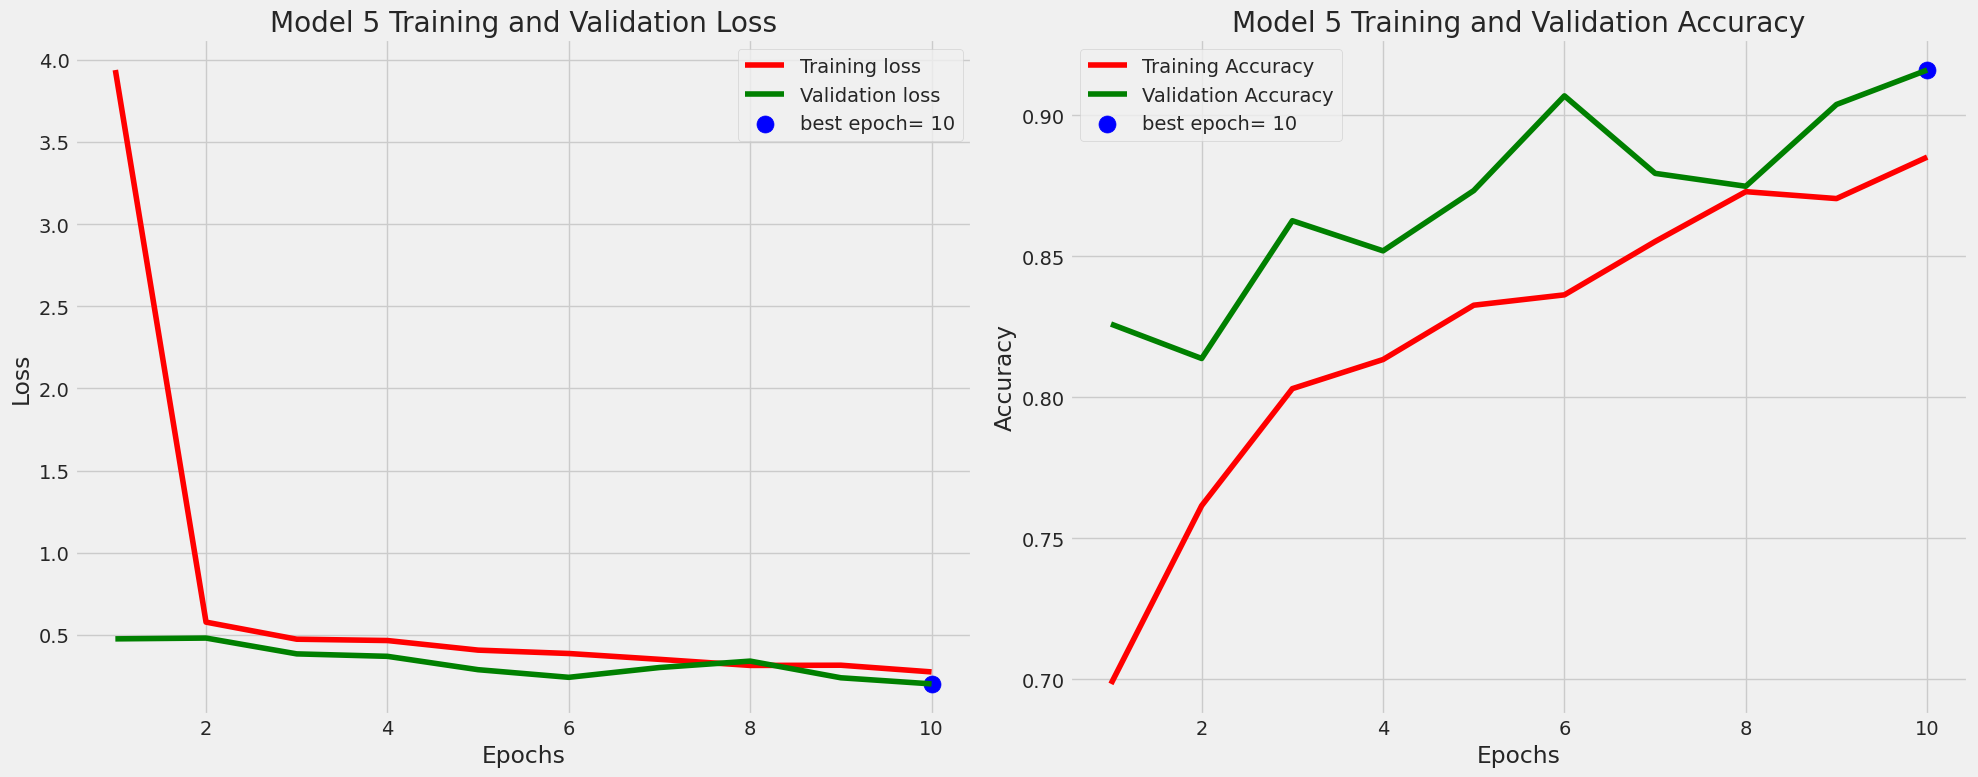

In [ ]:
# Define needed variables for model_densenet
tr_acc_model5 = history_densenet.history['accuracy']
tr_loss_model5 = history_densenet.history['loss']
val_acc_model5 = history_densenet.history['val_accuracy']
val_loss_model5 = history_densenet.history['val_loss']
index_loss_model5 = np.argmin(val_loss_model5)
val_lowest_model5 = val_loss_model5[index_loss_model5]
index_acc_model5 = np.argmax(val_acc_model5)
acc_highest_model5 = val_acc_model5[index_acc_model5]

Epochs_model5 = [i+1 for i in range(len(tr_acc_model5))]
loss_label_model5 = f'best epoch= {str(index_loss_model5 + 1)}'
acc_label_model5 = f'best epoch= {str(index_acc_model5 + 1)}'

# Plot training history for model5
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model5, tr_loss_model5, 'r', label='Training loss')
plt.plot(Epochs_model5, val_loss_model5, 'g', label='Validation loss')
plt.scatter(index_loss_model5 + 1, val_lowest_model5, s=150, c='blue', label=loss_label_model5)
plt.title('Model 5 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model5, tr_acc_model5, 'r', label='Training Accuracy')
plt.plot(Epochs_model5, val_acc_model5, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model5 + 1, acc_highest_model5, s=150, c='blue', label=acc_label_model5)
plt.title('Model 5 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluate Model

In [ ]:
##CNN
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 1.0000 - loss: 1.4819e-04
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9468 - loss: 0.2748
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9350 - loss: 0.5135
Train Loss:  0.00015170063124969602
Train Accuracy:  1.0
--------------------
Validation Loss:  0.24559855461120605
Validation Accuracy:  0.9496183395385742
--------------------
Test Loss:  0.44566935300827026
Test Accuracy:  0.9420731663703918


In [ ]:
#MLP Tensorflow
train_score_model2 = model2.evaluate(train_gen, verbose=1)
valid_score_model2 = model2.evaluate(valid_gen, verbose=1)
test_score_model2 = model2.evaluate(test_gen, verbose=1)

print("Model 2 Train Loss: ", train_score_model2[0])
print("Model 2 Train Accuracy: ", train_score_model2[1])
print('-' * 20)
print("Model 2 Validation Loss: ", valid_score_model2[0])
print("Model 2 Validation Accuracy: ", valid_score_model2[1])
print('-' * 20)
print("Model 2 Test Loss: ", test_score_model2[0])
print("Model 2 Test Accuracy: ", test_score_model2[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.8639 - loss: 9.7551
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7976 - loss: 19.4942
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8276 - loss: 28.6614
Model 2 Train Loss:  9.392707824707031
Model 2 Train Accuracy:  0.8707982897758484
--------------------
Model 2 Validation Loss:  21.067338943481445
Model 2 Validation Accuracy:  0.7847328186035156
--------------------
Model 2 Test Loss:  29.039527893066406
Model 2 Test Accuracy:  0.8140243887901306


In [ ]:
#VGG16
train_score_model3 = model3.evaluate(train_gen, verbose=1)
valid_score_model3 = model3.evaluate(valid_gen, verbose=1)
test_score_model3 = model3.evaluate(test_gen, verbose=1)

print("Model 3 Train Loss: ", train_score_model3[0])
print("Model 3 Train Accuracy: ", train_score_model3[1])
print('-' * 20)
print("Model 3 Validation Loss: ", valid_score_model3[0])
print("Model 3 Validation Accuracy: ", valid_score_model3[1])
print('-' * 20)
print("Model 3 Test Loss: ", test_score_model3[0])
print("Model 3 Test Accuracy: ", test_score_model3[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.9908 - loss: 0.0302
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9668 - loss: 0.2441
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9442 - loss: 0.6147
Model 3 Train Loss:  0.03226795420050621
Model 3 Train Accuracy:  0.9894958138465881
--------------------
Model 3 Validation Loss:  0.3275482654571533
Model 3 Validation Accuracy:  0.9633587598800659
--------------------
Model 3 Test Loss:  0.47501200437545776
Model 3 Test Accuracy:  0.9466463327407837


In [ ]:
#Resenet
train_score_model4 = model_resnet.evaluate(train_gen, verbose=1)
valid_score_model4 = model_resnet.evaluate(valid_gen, verbose=1)
test_score_model4 = model_resnet.evaluate(test_gen, verbose=1)

print("Model 4 Train Loss: ", train_score_model4[0])
print("Model 4 Train Accuracy: ", train_score_model4[1])
print('-' * 20)
print("Model 4 Validation Loss: ", valid_score_model4[0])
print("Model 4 Validation Accuracy: ", valid_score_model4[1])
print('-' * 20)
print("Model 4 Test Loss: ", test_score_model4[0])
print("Model 4 Test Accuracy: ", test_score_model4[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9971 - loss: 0.0123
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9792 - loss: 0.1614
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9630 - loss: 0.3054
Model 4 Train Loss:  0.009081006050109863
Model 4 Train Accuracy:  0.9971988797187805
--------------------
Model 4 Validation Loss:  0.2927452623844147
Model 4 Validation Accuracy:  0.9679389595985413
--------------------
Model 4 Test Loss:  0.27961114048957825
Model 4 Test Accuracy:  0.9603658318519592


In [ ]:
#DenseNet121
train_score_model5 = model_densenet.evaluate(train_gen, verbose=1)
valid_score_model5 = model_densenet.evaluate(valid_gen, verbose=1)
test_score_model5 = model_densenet.evaluate(test_gen, verbose=1)

print("Model 5 Train Loss: ", train_score_model5[0])
print("Model 5 Train Accuracy: ", train_score_model5[1])
print('-' * 20)
print("Model 5 Validation Loss: ", valid_score_model5[0])
print("Model 5 Validation Accuracy: ", valid_score_model5[1])
print('-' * 20)
print("Model 5 Test Loss: ", test_score_model5[0])
print("Model 5 Test Accuracy: ", test_score_model5[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9613 - loss: 0.1045
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9233 - loss: 0.1956
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8844 - loss: 0.2942
Model 5 Train Loss:  0.10876397788524628
Model 5 Train Accuracy:  0.9599089622497559
--------------------
Model 5 Validation Loss:  0.2023027092218399
Model 5 Validation Accuracy:  0.9160305261611938
--------------------
Model 5 Test Loss:  0.2662929892539978
Model 5 Test Accuracy:  0.9009146094322205


## Get Predictions

In [ ]:
#CNN
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


In [ ]:
#MLP
preds_model2 = model2.predict(test_gen)
y_pred_model2 = np.argmax(preds_model2, axis=1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


In [ ]:
#VGG16
preds_model3 = model3.predict(test_gen)
y_pred_model3 = np.argmax(preds_model3, axis=1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step


In [ ]:
#Resnet
preds_model4 = model_resnet.predict(test_gen)
y_pred_model4 = np.argmax(preds_model4, axis=1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step


In [ ]:
#VGG16
preds_model5 = model_densenet.predict(test_gen)
y_pred_model5 = np.argmax(preds_model5, axis=1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step


## Confusion Matrices and Classification report

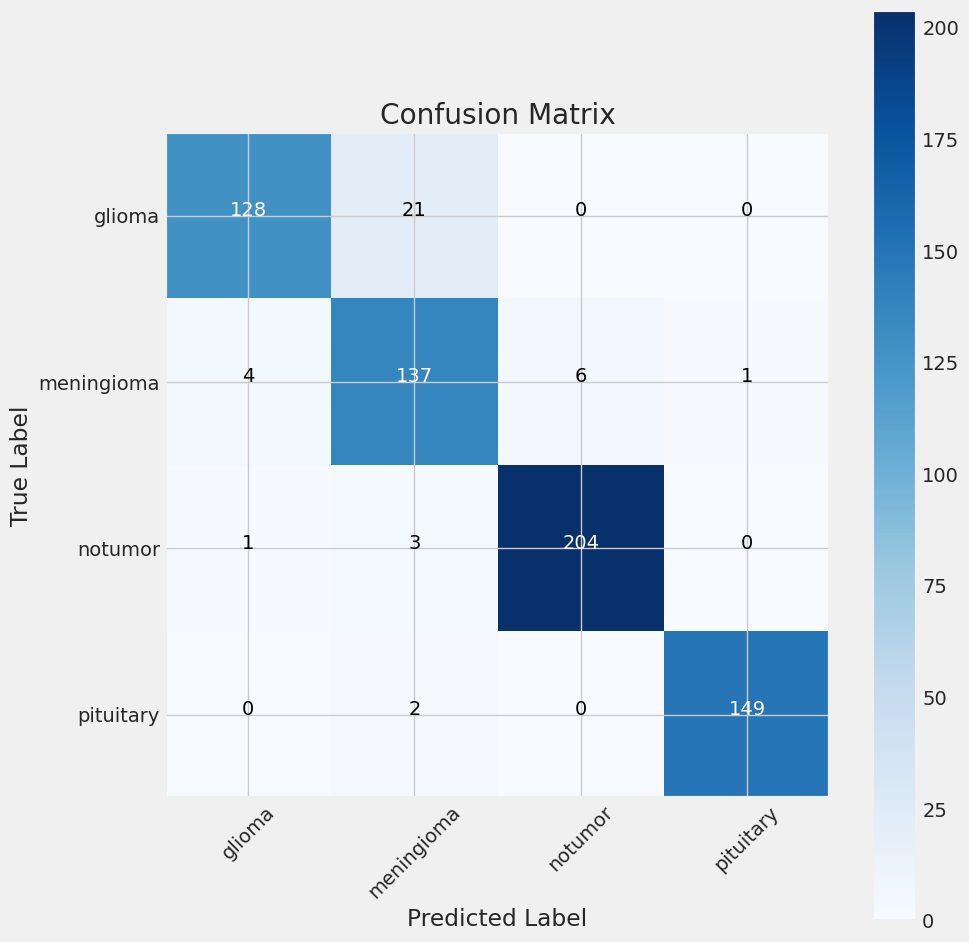

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

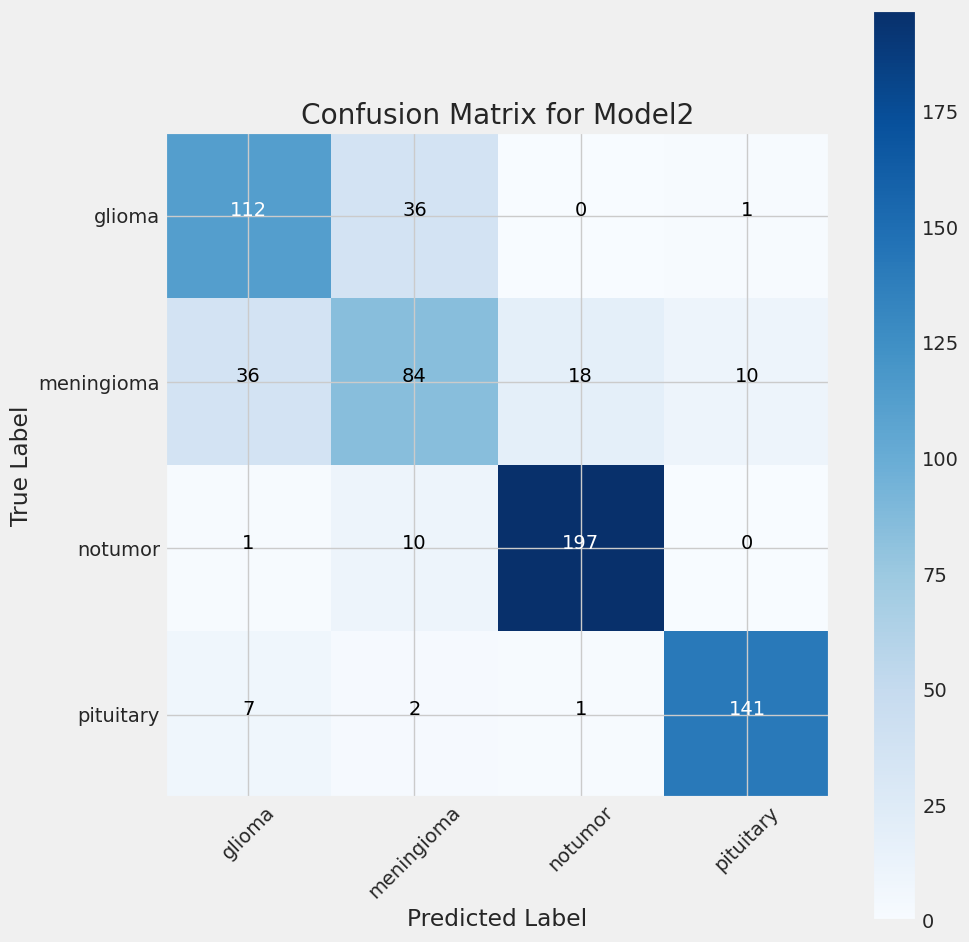

In [ ]:
g_dict_model2 = test_gen.class_indices
classes_model2 = list(g_dict_model2.keys())

# Confusion matrix for model2
cm_model2 = confusion_matrix(test_gen.classes, y_pred_model2)
cm_model2

plt.figure(figsize= (10, 10))
plt.imshow(cm_model2, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix for Model2')
plt.colorbar()

tick_marks_model2 = np.arange(len(classes_model2))
plt.xticks(tick_marks_model2, classes_model2, rotation= 45)
plt.yticks(tick_marks_model2, classes_model2)

thresh_model2 = cm_model2.max() / 2.
for i, j in itertools.product(range(cm_model2.shape[0]), range(cm_model2.shape[1])):
    plt.text(j, i, cm_model2[i, j], horizontalalignment= 'center', color= 'white' if cm_model2[i, j] > thresh_model2 else 'black')


plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


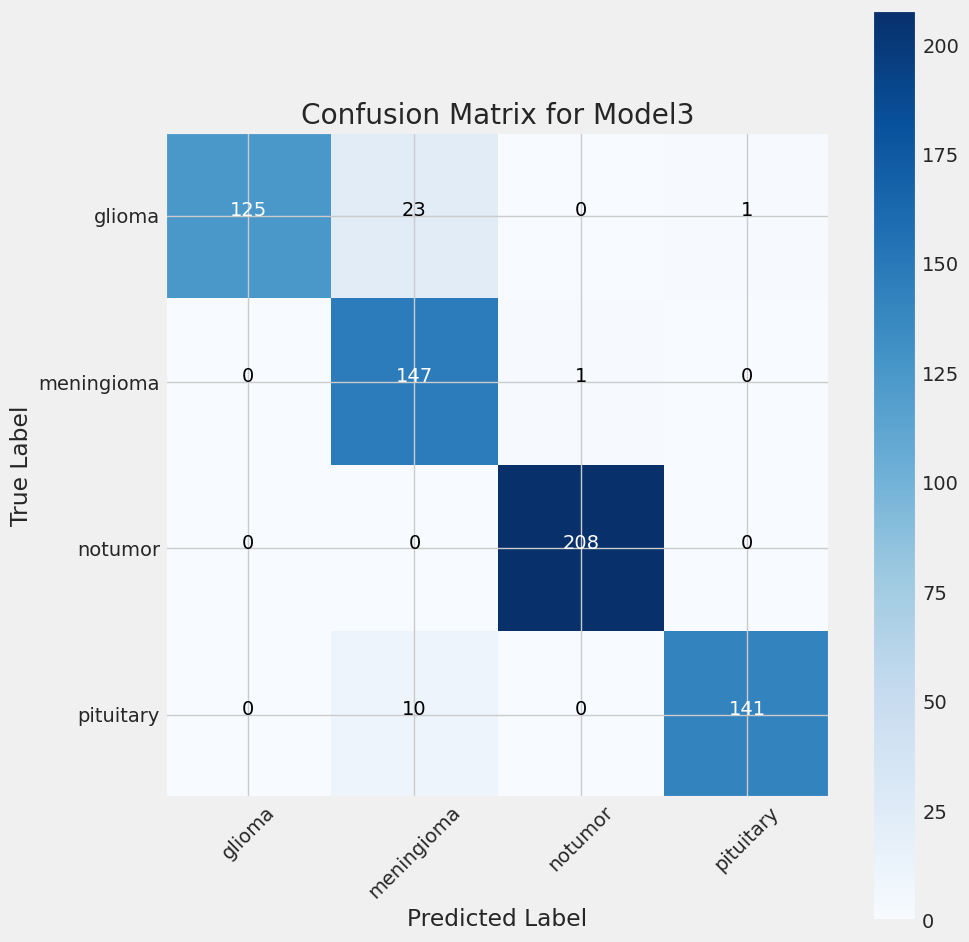

In [ ]:
g_dict_model3 = test_gen.class_indices
classes_model3 = list(g_dict_model3.keys())

# Confusion matrix for model3
cm_model3 = confusion_matrix(test_gen.classes, y_pred_model3)
cm_model3

plt.figure(figsize= (10, 10))
plt.imshow(cm_model3, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix for Model3')
plt.colorbar()

tick_marks_model3 = np.arange(len(classes_model3))
plt.xticks(tick_marks_model3, classes_model3, rotation= 45)
plt.yticks(tick_marks_model3, classes_model3)

thresh_model3 = cm_model3.max() / 2.
for i, j in itertools.product(range(cm_model3.shape[0]), range(cm_model3.shape[1])):
    plt.text(j, i, cm_model3[i, j], horizontalalignment= 'center', color= 'white' if cm_model3[i, j] > thresh_model3 else 'black')


plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


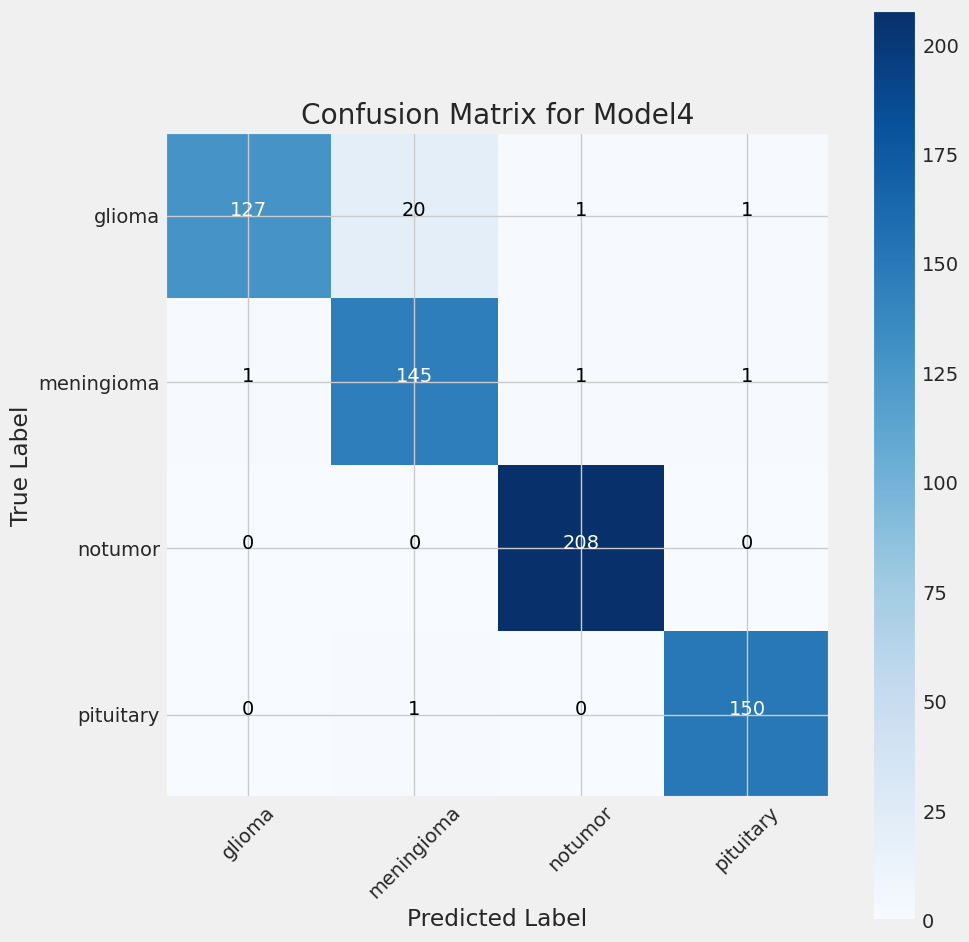

In [ ]:
# Resnet
g_dict_model4 = test_gen.class_indices
classes_model4 = list(g_dict_model4.keys())

# Confusion matrix for model4
cm_model4 = confusion_matrix(test_gen.classes, y_pred_model4)
cm_model4

plt.figure(figsize=(10, 10))
plt.imshow(cm_model4, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Model4')
plt.colorbar()

tick_marks_model4 = np.arange(len(classes_model4))
plt.xticks(tick_marks_model4, classes_model4, rotation=45)
plt.yticks(tick_marks_model4, classes_model4)

thresh_model4 = cm_model4.max() / 2.
for i, j in itertools.product(range(cm_model4.shape[0]), range(cm_model4.shape[1])):
    plt.text(j, i, cm_model4[i, j], horizontalalignment='center',
             color='white' if cm_model4[i, j] > thresh_model4 else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


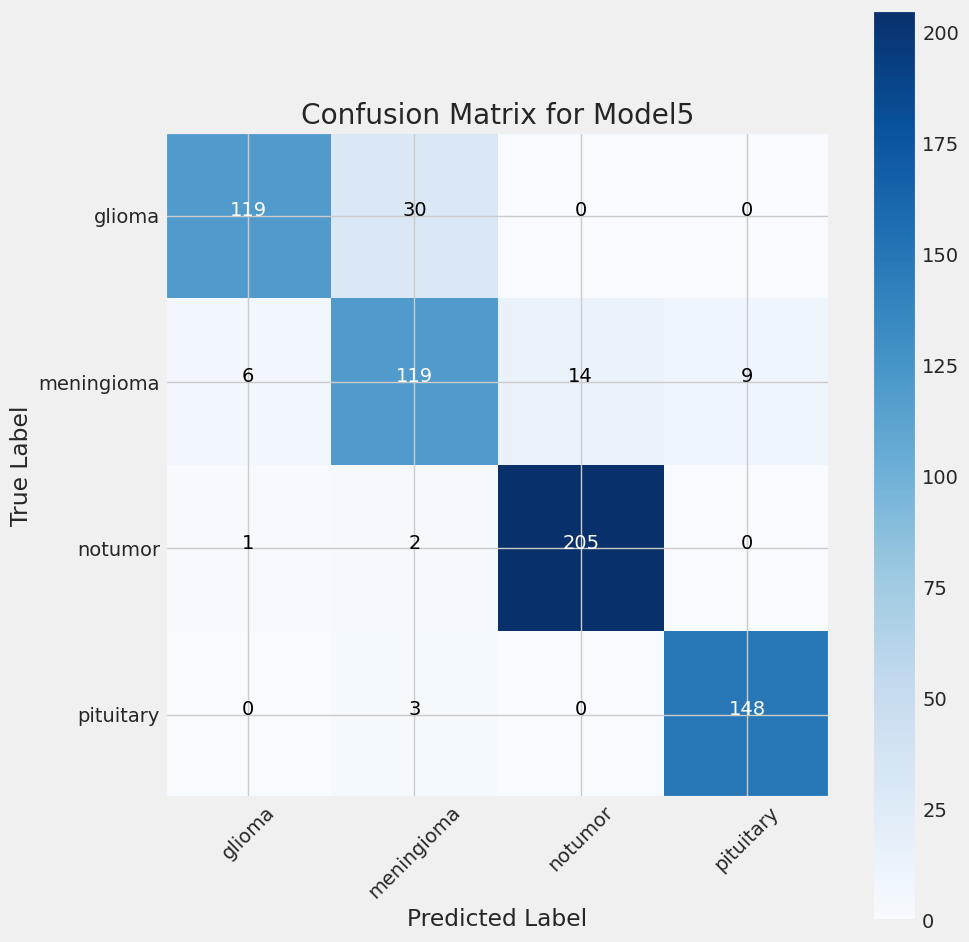

In [ ]:
# DenseNet121
g_dict_model5 = test_gen.class_indices
classes_model5 = list(g_dict_model5.keys())

# Confusion matrix for model5
cm_model5 = confusion_matrix(test_gen.classes, y_pred_model5)
cm_model5

plt.figure(figsize=(10, 10))
plt.imshow(cm_model5, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Model5')
plt.colorbar()

tick_marks_model5 = np.arange(len(classes_model5))
plt.xticks(tick_marks_model5, classes_model5, rotation=45)
plt.yticks(tick_marks_model5, classes_model5)

thresh_model5 = cm_model5.max() / 2.
for i, j in itertools.product(range(cm_model5.shape[0]), range(cm_model5.shape[1])):
    plt.text(j, i, cm_model5[i, j], horizontalalignment='center',
             color='white' if cm_model5[i, j] > thresh_model5 else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
#CNN Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.96      0.86      0.91       149
  meningioma       0.84      0.93      0.88       148
     notumor       0.97      0.98      0.98       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.94       656
   macro avg       0.94      0.94      0.94       656
weighted avg       0.94      0.94      0.94       656



In [ ]:
#MLP Classificatoin Report
print(classification_report(test_gen.classes, y_pred_model2, target_names= classes_model2))


              precision    recall  f1-score   support

      glioma       0.72      0.75      0.73       149
  meningioma       0.64      0.57      0.60       148
     notumor       0.91      0.95      0.93       208
   pituitary       0.93      0.93      0.93       151

    accuracy                           0.81       656
   macro avg       0.80      0.80      0.80       656
weighted avg       0.81      0.81      0.81       656



In [ ]:
#VGG16 Classification Report
print(classification_report(test_gen.classes, y_pred_model3, target_names= classes_model3))


              precision    recall  f1-score   support

      glioma       1.00      0.84      0.91       149
  meningioma       0.82      0.99      0.90       148
     notumor       1.00      1.00      1.00       208
   pituitary       0.99      0.93      0.96       151

    accuracy                           0.95       656
   macro avg       0.95      0.94      0.94       656
weighted avg       0.96      0.95      0.95       656



In [ ]:
#ResNet Classification Report
print(classification_report(test_gen.classes, y_pred_model4, target_names= classes_model4))


              precision    recall  f1-score   support

      glioma       0.99      0.85      0.92       149
  meningioma       0.87      0.98      0.92       148
     notumor       0.99      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656



In [ ]:
#DenseNet Classification Report
print(classification_report(test_gen.classes, y_pred_model5, target_names= classes_model5))


              precision    recall  f1-score   support

      glioma       0.94      0.80      0.87       149
  meningioma       0.77      0.80      0.79       148
     notumor       0.94      0.99      0.96       208
   pituitary       0.94      0.98      0.96       151

    accuracy                           0.90       656
   macro avg       0.90      0.89      0.89       656
weighted avg       0.90      0.90      0.90       656

